In [ ]:
import pandas as pd 
import numpy as np 
from google.colab import drive
drive.mount('/content/drive')
LIBRARY_PATH = '/content/drive/MyDrive/NLP PROJECT/'


!pip install emoji
import re
import string 
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import regex
from collections import Counter
import nltk
import seaborn as sns
nltk.download('stopwords')
import gensim
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
stop_words = set(stopwords.words('english'))
from gensim.parsing.preprocessing import strip_non_alphanum
from gensim.parsing.preprocessing import strip_numeric
from nltk.tokenize import TweetTokenizer
import emoji 
import json 

Mounted at /content/drive
     |████████████████████████████████| 175 kB 10.1 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=492f3e763266229ed426861c2c2999014e04e1bbe8c65c4f6bc0460314175e1f
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train_data = pd.read_csv(LIBRARY_PATH + 'twitter_dataset/train.csv')

test_data = pd.read_csv(LIBRARY_PATH + 'twitter_dataset/test.csv')

In [ ]:
print(len(train_data))
print(len(test_data))

7613
3263


In [ ]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train_data.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

## Tweets Pre-Processing  

### Cleaning Pipeline 

In [ ]:

PunctChars = r'''[`'“".?!,:;]'''
Punct = '%s+' % PunctChars
Entity = '&(amp|lt|gt|quot);'
printable = set(string.printable)
f = open("/content/drive/MyDrive/NLP PROJECT/contractions.json")
contractions = json.load(f)


def remove_contractions(text):    
    return  " ".join([ contractions[word] if word in contractions else word for word in text.split() ] )


def regex_or(*items):
    r = '|'.join(items)
    r = '(' + r + ')'
    return r

def pos_lookahead(r):
    return '(?=' + r + ')'

def neg_lookahead(r):
    return '(?!' + r + ')'

def optional(r):
    return '(%s)?' % r

 
def process_Mentions(transient_tweet_text):
    '''
    Identify mentions if any
    '''
#     transient_tweet_text = re.sub(r"@(\w+)",'@mention' , transient_tweet_text)
    transient_tweet_text =  re.sub("@[A-Za-z0-9]+","", transient_tweet_text)
    return transient_tweet_text



def remove_rt(tweet):
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    return tweet


def process_URLs(transient_tweet_text):
    '''
    replace all URLs in the tweet text
    '''
    UrlStart1 = regex_or('https?://', r'www\.',r'bit.ly/')
    CommonTLDs = regex_or('com','co\\.uk','org','net','info','ca','biz','info','edu','in','au')
    UrlStart2 = r'[a-z0-9\.-]+?' + r'\.' + CommonTLDs + pos_lookahead(r'[/ \W\b]')
    UrlBody = r'[^ \t\r\n<>]*?'  # * not + for case of:  "go to bla.com." -- don't want period
    UrlExtraCrapBeforeEnd = '%s+?' % regex_or(PunctChars, Entity)
    UrlEnd = regex_or( r'\.\.+', r'[<>]', r'\s', '$')
    Url = 	(optional(r'\b') + 
            regex_or(UrlStart1, UrlStart2) + 
            UrlBody + 
    pos_lookahead( optional(UrlExtraCrapBeforeEnd) + UrlEnd))

    Url_RE = re.compile("(%s)" % Url, re.U|re.I)
    transient_tweet_text = re.sub(Url_RE, "", transient_tweet_text)

    # fix to handle unicodes in URL
    URL_regex2 = r'\b(htt)[p\:\/]*([\\x\\u][a-z0-9]*)*'
    transient_tweet_text = re.sub(URL_regex2, "", transient_tweet_text)
    return transient_tweet_text


def split_count_emojis(text,emoji_list):
    data  = regex.findall(r'\X', text)
    flags = regex.findall(u'[\U0001F1E6-\U0001F1FF]', text)

    for word in data:
        if any(char in emoji.UNICODE_EMOJI['en'] for char in word):
            if word not in emoji_list:
                    emoji_list[word] = 1 
            else:
                    emoji_list[word] +=1
        
    for f in flags:
        if any(char in emoji.UNICODE_EMOJI['en'] for char in f):
            if f not in emoji_list:
                emoji_list[f] = 1 
            else:
                emoji_list[f] +=1


def translate_emojis(text):
    text =  emoji.demojize(text)
    text.replace("_"," ")
    text.replace(":"," ")
    return text

def to_LowerCase(transient_tweet_text):
    # convert text to lower 
    transient_tweet_text = transient_tweet_text.lower()
    return transient_tweet_text



def hashtags(text):
    hashtags = re.findall(r"#(\w+)", text)
    return hashtags


def cleaner_with_stopwords(tweet):
    #  translate emojis 
    tweet = to_LowerCase(tweet)
    tweet = remove_contractions(tweet)
    tweet = translate_emojis(tweet)
    tweet = process_Mentions(tweet) #Remove @ sign
    tweet = tweet.replace("_","")# remove underscore
    tweet = re.sub(r'\brt\b',' ',tweet).strip()   # remove rt tag 
    tweet = remove_rt(tweet)
    #Remove http links
    tweet = process_URLs(tweet)
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    tweet = re.sub(r'(.)\1+', r'\1\1', tweet)  # prune consecutive characters
    tweet = tweet.strip()  # strip  leading and trailing white spaces 
    tweet = re.sub(r'[\s]+', ' ', tweet) # strip all white spaces
    tweet = strip_numeric(tweet)
    tweet = strip_non_alphanum(tweet)
    return tweet


def cleaner_without_stopwords(tweet):
        #  translate emojis 
    tweet = to_LowerCase(tweet)
    tweet = remove_contractions(tweet)
    # custom special characters removal 
    tweet = tweet.replace('û',"")
    tweet = translate_emojis(tweet)
    tweet = process_Mentions(tweet) #Remove @ sign
    tweet = tweet.replace("_","")# remove underscore
    tweet = re.sub(r'\brt\b',' ',tweet).strip()   # remove rt tag 
    tweet = remove_rt(tweet)
    # tweet = re.sub(r"(:\|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = process_URLs(tweet)
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    tweet = re.sub(r'(.)\1+', r'\1\1', tweet)  # prune consecutive characters
    tweet = tweet.strip()  # strip  leading and trailing white spaces 
    tweet = re.sub(r'[\s]+', ' ', tweet) # strip all white spaces
    tweet = strip_numeric(tweet)
    tweet = strip_non_alphanum(tweet)
    tweet = [word for word in tweet.split() if  word not in stop_words]
    tweet = " ".join(tweet)
    #Emoji line
    # for emot in emojis_translate:
    #     # tweet = tweet.replace(emot, " ".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split()))
    #     tweet = tweet.replace(emot, "".join(emojis_translate[emot]))
    return tweet


### Executing Cleaning Process

In [ ]:
train_data['hashtags'] =  train_data.text.apply(lambda x: hashtags(x))
test_data['hashtags'] = test_data.text.apply(lambda x: hashtags(x))

In [ ]:
train_data['text without sw'] = train_data.text.apply(lambda x : cleaner_without_stopwords(x))
test_data['text without sw'] = test_data.text.apply(lambda x : cleaner_without_stopwords(x))
train_data['text with sw'] = train_data.text.apply(lambda x : cleaner_with_stopwords(x))
test_data['text with sw'] = test_data.text.apply(lambda x: cleaner_with_stopwords(x))

In [ ]:
outfile1 = 'clean_train.csv'
outfile2 = 'clean_test.csv'


df_train.to_csv(outfile1)
df_test.to_csv(outfile2)

!mv "/content/clean_train.csv" "/content/drive/MyDrive/NLP PROJECT/preprocessed_data/"
!mv "/content/clean_test.csv" "/content/drive/MyDrive/NLP PROJECT/preprocessed_data/"


## Exploratory Data Analysis 

In [ ]:
import pandas as pd 
import numpy as np 
from google.colab import drive
drive.mount('/content/drive')
LIBRARY_PATH = '/content/drive/MyDrive/NLP PROJECT/'

Mounted at /content/drive


In [ ]:
df_train = pd.read_csv(LIBRARY_PATH + "preprocessed_data/clean_train.csv")
df_test = pd.read_csv(LIBRARY_PATH + "preprocessed_data/clean_test.csv")

In [ ]:
df_train.head()

,Unnamed: 0,id,keyword,location,text,target,hastags,text without sw,text with sw
0,0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,['earthquake'],deeds reason earthquake may allah forgive us,our deeds are the reason of this earthquake ma...
1,1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,[],forest fire near la ronge sask canada,forest fire near la ronge sask canada
2,2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,[],residents asked shelter place notified officer...,all residents asked to shelter in place are ...
3,3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,['wildfires'],people receive wildfires evacuation orders cal...,people receive wildfires evacuation orders i...
4,4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"['Alaska', 'wildfires']",got sent photo ruby alaska smoke wildfires pou...,just got sent this photo from ruby alaska as s...


In [ ]:
colours = {"0": "rgb(0,255,0)",
           "1": "rgb(255,0,0)"}

fig = px.bar(df_train, x=df_train['target'].unique(), y = df_train['target'].value_counts(),color_discrete_map =colours,color=df_train['target'].unique())
fig.update_layout(title= 'Number of Disaster vs Non Disaster Tweets')
fig.update_xaxes(title='Class')
fig.update_yaxes(title='Count')
fig.show()

In [ ]:
missing_values = df_train.isna().sum()
missing_values

Unnamed: 0       0
id               0
keyword         61
location      2533
text             0
target           0
hastags          0
dtype: int64

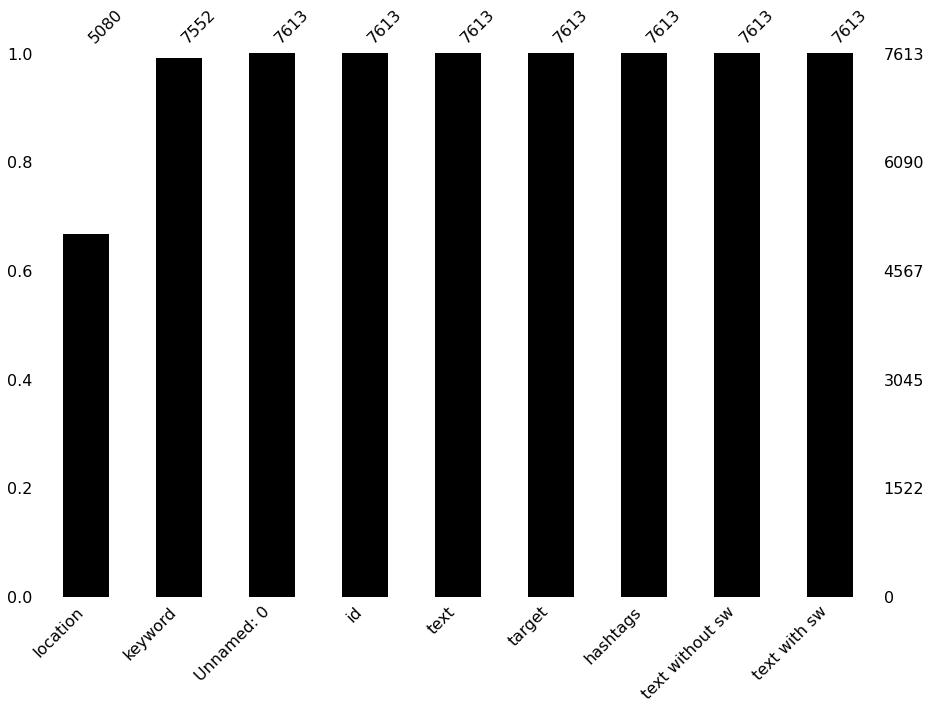

In [ ]:
import missingno as msno
msno.bar(df_train, color = (0, 0, 0), sort = "ascending", figsize = (15, 10))
plt.show()

# some keywords and locations are missing, we can randomly inpute the data .

## Word distribution in Disaster tweets vs non - Disaster tweets

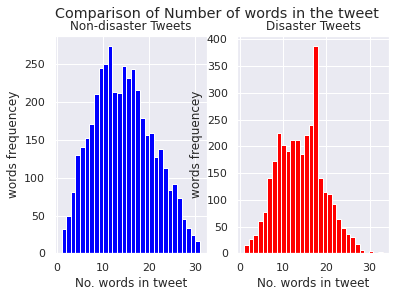

In [ ]:
sns.set(style='darkgrid')
fig, axes = plt.subplots(1, 2)
fig.suptitle('Comparison of Number of words in the tweet')

axes[0].hist(df_train[df_train['target'] == 0]['text with sw'].str.split().map(lambda word: len(word)),
             bins=30, color='blue')
axes[0].set_ylabel('words frequencey')
axes[0].set_xlabel('No. words in tweet')
axes[0].set_title('Non-disaster Tweets')


axes[1].hist(df_train[df_train['target'] == 1]['text with sw'].str.split().map(lambda word: len(word)),
             bins=30, color='red', label='Disaster')
axes[1].set_ylabel('words frequencey')
axes[1].set_xlabel('No. words in tweet')
axes[1].set_title('Disaster Tweets')

plt.show()

#  word distribution follows a similar distribution in average.

In [ ]:
df_train = pd.read_csv(LIBRARY_PATH + "preprocessed_data/clean_train.csv")
test = pd.read_csv(LIBRARY_PATH + "preprocessed_data/clean_test.csv")

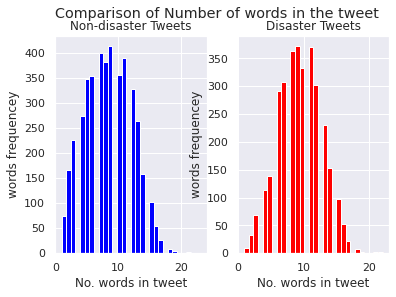

In [ ]:
sns.set(style='darkgrid')
fig, axes = plt.subplots(1, 2)
fig.suptitle('Comparison of Number of words in the tweet')

axes[0].hist(df_train[df_train['target'] == 0]['text without sw_freq'].str.split().map(lambda word: len(word)),
             bins=30, color='blue')
axes[0].set_ylabel('words frequencey')
axes[0].set_xlabel('No. words in tweet')
axes[0].set_title('Non-disaster Tweets')


axes[1].hist(df_train[df_train['target'] == 1]['text without sw_freq'].str.split().map(lambda word: len(word)),
             bins=30, color='red', label='Disaster')
axes[1].set_ylabel('words frequencey')
axes[1].set_xlabel('No. words in tweet')
axes[1].set_title('Disaster Tweets')

plt.show()

#  word distribution follows a similar distribution in average.

In [ ]:
df_train['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

### Do twees with similar keywords talk about similar incidents ? for example annihilated , annihilation

In [ ]:
keywords = df_train.groupby('keyword')

In [ ]:
keywords.describe().head()

Unnamed: 0                                          \
                         count   mean        std    min     25%    50%   
keyword                                                                  
ablaze                    36.0   48.5  10.535654   31.0   39.75   48.5   
accident                  35.0   84.0  10.246951   67.0   75.50   84.0   
aftershock                34.0  118.5   9.958246  102.0  110.25  118.5   
airplane%20accident       35.0  153.0  10.246951  136.0  144.50  153.0   
ambulance                 38.0  189.5  11.113055  171.0  180.25  189.5   

                                      id              ...                 \
                        75%    max count        mean  ...     75%    max   
keyword                                               ...                  
ablaze                57.25   66.0  36.0   70.388889  ...   81.25   95.0   
accident              92.50  101.0  35.0  121.800000  ...  134.50  145.0   
aftershock           126.75  135.0  34.0  171.323529  ...  182.75  195.0   
airplane%20accident  161.50  170.0  35.0  220.142857  ...  233.50  245.0   
ambulance            198.75  208.0  38.0  269.052632  ...  279.75  294.0   

                    target                                               
                     count      mean       std  min  25%  50%  75%  max  
keyword                                                                  
ablaze                36.0  0.361111  0.487136  0.0  0.0  0.0  1.0  1.0  
accident              35.0  0.685714  0.471008  0.0  0.0  1.0  1.0  1.0  
aftershock            34.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
airplane%20accident   35.0  0.857143  0.355036  0.0  1.0  1.0  1.0  1.0  
ambulance             38.0  0.526316  0.506009  0.0  0.0  1.0  1.0  1.0  

[5 rows x 24 columns]

### most frequent words in non disaster vs disaster tweets

# New Section

In [ ]:

#  check frequent words in each class to see if there are any similarities .
counter = Counter()

disaster = df_train.loc[df_train['target'] == 1]
non_disaster = df_train.loc[df_train['target']==0]

for text in disaster['text without sw'].values:
    for word in text.split():
        counter[word] += 1
top_disaster = counter.most_common(20)


for text in non_disaster['text without sw'].values:
    for word in text.split():
        counter[word] += 1
top_nondisaster = counter.most_common(20)

In [ ]:
x= []
y = []

for i in range(len(top_disaster)):
    a ,b = top_disaster[i]
    x.append(a)
    y.append(b)
  
fig = px.bar(x=x,y=y,color=y,title='Most common words in Disaster tweets')
fig.show()

In [ ]:
x= []
y = []

for i in range(len(top_nondisaster)):
    a ,b = top_nondisaster[i]
    x.append(a)
    y.append(b)
  
fig = px.bar(x=x,y=y,color=y,title='Most common words in Non Disaster tweets')
fig.show()

### removing some of the most frequent words

In [ ]:
disaster_words = ['fire', 'kill', 'bomb', 'disaster', 'crash', 'flood',
                  'suicide', 'police', 'attack', 'storm', 'emergency', 'burn','hiroshima',]

nondisaster_words = ['amp','like', 'new', 'body', 'love', 'good','via']

In [ ]:
def words_counter_removal(dataframe,column,frequency,ascending=False):
    counter = Counter()
    for tweet in dataframe[column].values:

        for word in tweet.split():
            counter[word] += 1
    
    # Words should not be detected
    for word in disaster_words + nondisaster_words:
        counter.pop(word)
    
    if not ascending:
        return set([word for (word, counts) in counter.most_common(frequency)])
    else:
        return set([word for (word, counts) in counter.most_common()[:-frequency-1:-1]])

def remove_freqwords(text,freq_words):
    return " ".join([word for word in str(text).split() if word not in freq_words])


In [ ]:
df_train.dropna(subset=['text without sw'],inplace = True)
df_test.dropna(subset=['text without sw'],inplace= True)

In [ ]:
train_freq_words = words_counter_removal(df_train,'text without sw',20)
test_freq_words = words_counter_removal(df_test,'text without sw',20)



In [ ]:
df_train['text without sw_freq'] = df_train['text without sw'].apply(lambda x: remove_freqwords(x, train_freq_words))
df_test['text without sw_freq'] = df_test['text without sw'].apply(lambda x: remove_freqwords(x, test_freq_words))

In [ ]:
#  rare words 
train_freq_words = words_counter_removal(df_train,'text without sw',10,True)
test_freq_words = words_counter_removal(df_test,'text without sw',10,True)


In [ ]:

df_train['text without sw_freq'] = df_train['text without sw'].apply(lambda x: remove_freqwords(x, train_freq_words))
df_test['text without sw_freq'] = df_test['text without sw'].apply(lambda x: remove_freqwords(x, test_freq_words))